In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn import datasets 
data = datasets.load_iris() 
#create a DataFrame 
df = pd.DataFrame(data.data, columns=data.feature_names) 
df['Target'] = pd.DataFrame(data.target)
print(df.shape)
df.head()

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [8]:
#visualisasi hasil ConvexHull
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from initHull import NewConvexHull
plt.figure(figsize = (10, 6))
colors = ['b','r','g']
plt.title('Petal Width vs Petal Length')
plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])
for i in range(len(data.target_names)):
    bucket = df[df['Target'] == i]              # untuk mengambil data dengan target yang seragam
    bucket = bucket.iloc[:,[0,1]].values        # untuk mendapatkan aray berupa posisi x dan y, berukuran n x 2, n adalah banyak data
    hull = ConvexHull(bucket)                   # bagian ini diganti dengan hasil implementasi ConvexHull Divide & Conquer
    sim = NewConvexHull(bucket)
    plt.scatter(bucket[:, 0], bucket[:, 1], label=data.target_names[i])
    for simplex in sim:
        plt.plot(bucket[simplex, 0], bucket[simplex, 1], colors[i])
plt.legend()

ImportError: cannot import name 'NewConvexHull' from 'initHull' (g:\Git Repo\LINIER_SEPARABILITY_TEST\src\initHull.py)

In [ ]:
bucket0 = df[df['Target'] == 0]
bucket0.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
bucket0 = bucket0.iloc[:,[0,1]].values
bucket0

array([[5.1, 3.5],
       [4.9, 3. ],
       [4.7, 3.2],
       [4.6, 3.1],
       [5. , 3.6],
       [5.4, 3.9],
       [4.6, 3.4],
       [5. , 3.4],
       [4.4, 2.9],
       [4.9, 3.1],
       [5.4, 3.7],
       [4.8, 3.4],
       [4.8, 3. ],
       [4.3, 3. ],
       [5.8, 4. ],
       [5.7, 4.4],
       [5.4, 3.9],
       [5.1, 3.5],
       [5.7, 3.8],
       [5.1, 3.8],
       [5.4, 3.4],
       [5.1, 3.7],
       [4.6, 3.6],
       [5.1, 3.3],
       [4.8, 3.4],
       [5. , 3. ],
       [5. , 3.4],
       [5.2, 3.5],
       [5.2, 3.4],
       [4.7, 3.2],
       [4.8, 3.1],
       [5.4, 3.4],
       [5.2, 4.1],
       [5.5, 4.2],
       [4.9, 3.1],
       [5. , 3.2],
       [5.5, 3.5],
       [4.9, 3.6],
       [4.4, 3. ],
       [5.1, 3.4],
       [5. , 3.5],
       [4.5, 2.3],
       [4.4, 3.2],
       [5. , 3.5],
       [5.1, 3.8],
       [4.8, 3. ],
       [5.1, 3.8],
       [4.6, 3.2],
       [5.3, 3.7],
       [5. , 3.3]])

In [ ]:
hull0 = ConvexHull(bucket0)
hull0.simplices

array([[41, 13],
       [36, 41],
       [22, 13],
       [22, 32],
       [15, 14],
       [15, 32],
       [18, 14],
       [18, 36]], dtype=int32)

In [ ]:
for simpul in hull0.simplices:
    print(simpul)
    break
simpul
bucket0[simpul,0]
# bucket0[simpul,1]

[41 13]


array([4.5, 4.3])

In [ ]:
# bucket1 = df[df['Target'] == 1]
# bucket1.head()

In [ ]:
# bucket1 = bucket1.iloc[:,[0,1]].values
# hull1 = ConvexHull(bucket1)
# hull1.simplices

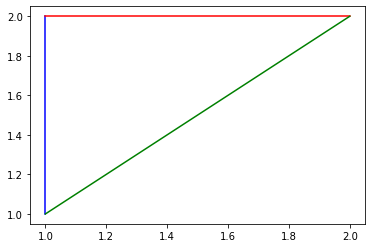

In [ ]:
plt.plot([1,1],[1,2],'b')
plt.plot([1,2],[2,2],'r')
plt.plot([2,1],[2,1],'g')